<a href="https://colab.research.google.com/github/Maxibrionest/MachineLearning/blob/main/Entrega3/Entrega3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Machine Learning, caso de estudio Monopoly/Dormammu**

Nombre: Maximiliano Briones / Lucas Vásquez

Sección: 003V

Evaluación: 3

Fecha de entrega: 01/12/2021

---


# **Fase I. Business Understanding.**

El banco "Monopoly" fue adquirido recientemente por el banco, con capitales extranjeros, "Dormammu". Éste encargó hacer estudios sobre la adquisición, determinando  comportamiento, patrones y una estrategia para abordar a los nuevos clientes.

En este estudio debemos presentar un análisis mediante aprendizaje no supervisado, seleccionando el modelo que presente mejores resultados en predicción y que su selección sea respaldada y justificada.


[Link a enunciado original](https://github.com/Maxibrionest/MachineLearning/blob/main/Entrega1/ET221_3A_MLY0100.docx).

# **Fase II. Data Understanding.**

> A continuación, se importan las librerías a utilizar.

In [124]:
#Librerías
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
#Preprocesamiento
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
#Imputación
from sklearn.impute import KNNImputer
#Estandarización
from sklearn.preprocessing import StandardScaler
#Normalización
from sklearn.preprocessing import MinMaxScaler
#Modelos Y Métricas
from sklearn.cluster import KMeans
#Clustering
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc
#PCA
from sklearn.decomposition import PCA
#DBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs


> Carga de Base de datos a través de Google Drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
sheetname = 'Transición de Negocio'
path_to_file = '/gdrive/MyDrive/DUOC/2021 - 2/MLY/Entrega2/Base_clientes_Monopoly.xlsx'
df = pd.read_excel(path_to_file, sheet_name=sheetname, header=1)

In [4]:
df

,Id,Subsegmento,Sexo,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,Consumo,Hipotecario,Debito,CambioPin,Cuentas,TC,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T12,FlgActCN_T12,FlgActCI_T12,FlgActAN_T12,FlgActAI_T12,FlgActPAT_T12,FlgActCCPC_T12,FlgActCCOT_T12,FlgActCOL_T12,Fac_T12,Txs_T12,FacCN_T12,TxsCN_T12,FacCI_T12,TxsCI_T12,FacAN_T12,TxsAN_T12,FacAI_T12,TxsAI_T12,...,FlgActCOL_T01,Fac_T01,Txs_T01,FacCN_T01,TxsCN_T01,FacCI_T01,TxsCI_T01,FacAN_T01,TxsAN_T01,FacAI_T01,TxsAI_T01,FacPAT_T01,TxsPAT_T01,FacCCPC_T01,TxsCCPC_T01,FacCCOT_T01,TxsCCOT_T01,FacCOL_T01,TxsCOL_T01,FacDebCom_T01,TxsDebCom_T01,FacDebAtm_T01,TxsDebAtm_T01,Col_T01,ColL1T0_T01,ColL1TE_T01,ColL2T0_T01,ColL2AC_T01,ColL2CC_T01,ColMx_T01,PagoNac_T01,PagoInt_T01,EeccNac_T01,EeccInt_T01,UsoL1_T01,UsoL2_T01,UsoLI_T01,IndRev_T01,target,Unnamed: 574
0,1,160,M,13.0,43,NaN,130,1,1,0,0,1,0,0,1,NaN,1,3,798000,1012000.0,1210.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,55490.0,3.0,55490.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,204133,28,24000,2,1069735.0,0,1040339.0,0,0,29396,0.0,33000,0.0,1099866.0,0.0,1099866.0,15080,0.0,R,0,NaN
1,2,160,H,13.0,46,143640.0,69,1,0,0,0,1,0,1,0,NaN,1,1,750000,150000.0,1000.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19813.0,1.0,19813.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,118247,1,118247,1,0,0,0,0,0,0,0,0,118247,1,0,0,0,0,0,0,0,0,211884.0,0,162939.0,48945,0,0,0.0,300000,0.0,214592.0,0.0,214592.0,83596,0.0,R,0,NaN
2,3,170,H,13.0,45,929106.0,24,1,1,0,0,1,0,1,1,1.0,1,2,1350000,200000.0,1500.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123950.0,3.0,123950.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,191336,3,191336,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,162161,9,519000,11,7400.0,7400,0.0,0,0,0,0.0,216676,0.0,0.0,0.0,7400.0,0,0.0,T,0,NaN
3,4,151,H,13.0,46,172447.0,134,0,1,0,1,0,0,0,0,1.0,1,2,1570800,220001.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,44470.0,3.0,44470.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,11890,1,11890,1,0,0,0,0,0,0,0,0,11890,1,0,0,0,0,0,0,0,0,262160.0,0,244048.0,18112,0,0,0.0,60000,0.0,272762.0,0.0,272762.0,10591,0.0,R,0,NaN
4,5,170,H,13.0,46,805250.0,116,0,1,1,0,1,0,1,0,1.0,2,3,2762000,2.0,6430.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,138225.0,6.0,138225.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,173576,10,173576,10,0,0,0,0,0,0,0,0,70808,3,47000,1,0,0,0,0,0,0,306161.0,60008,0.0,214125,0,32028,0.0,272925,0.0,249562.0,0.0,75339.0,377782,0.0,R,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,51120,160,H,13.0,51,364978.0,57,1,1,1,0,1,0,0,1,1.0,2,3,999000,1000.0,550.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,78520.0,9.0,78520.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,62808,5,62808,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1112000,14,463255.0,62808,379646.0,20801,0,0,0.0,300000,0.0,478320.0,0.0,478320.0,12668,0.0,R,0,NaN
51120,51121,170,H,13.0,51,625376.0,39,1,0,0,0,1,0,0,1,1.0,1,1,1744200,1.0,300.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6824.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,37783,1,0,0,0,0,0,0,0,0,37783,1,0,0,0,0,0,0,0,0,0,0,728406.0,37783,0.0,91896,0,598727,0.0,166098,0.0,166098.0,0.0,0.0,572363,0.0,R,0,NaN
51121,51122,160,H,13.0,47,806220.0,153,1,1,0,0,1,0,0,1,1.0,1,2,1061000,194700.0,1526.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,66040.0,3.0,66040.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24373.0,0,24.0,0,0,24349,0.0,18891,0.0,9652.0,0.0,9652.0,16241,0.0,R,0,NaN
51122,51123,160,M,13.0,47,NaN,11,1,0,0,0,1,0,0,0,NaN,1,1,1612000,300000.0,2300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,108982,2,108982,2,0,0,0,0,0,0,0,0,84982,1,0,0,0,0,0,0,0,0,52360.0,24000,33.0,28327,0,0,0.0,26528,0.0,24638.0,0.0,24638.0,84982,0.0,R,0,NaN


**Como sabemos los datos corresponden a un excel con actividad financiera de clientes del banco Monopoly, contiene una muestra de clientes con 12 meses de información almacenada en variables mensuales por cada cliente.**

In [5]:
#
print("Cantidad de observaciones: ", df.shape[0])
print("Cantidad de columnas:      ", df.shape[1])
print("Cantidad de datos:         ", df.shape[0] * df.shape[1])
observaciones = df.shape[0]

Cantidad de observaciones:  51124
Cantidad de columnas:       575
Cantidad de datos:          29396300


**Estamos frente un dataset grande superando los 29 millones de datos u observaciones. Pero como se mencionó, más adelante estaremos separando la data y quedándonos solo con lo que nos interesa y consideramos pertiente, por lo que es probable que ese número total disminuya en buena medida.**

In [6]:
df.dtypes

Id                int64
Subsegmento       int64
Sexo             object
Region          float64
Edad              int64
                 ...   
UsoL2_T01         int64
UsoLI_T01       float64
IndRev_T01       object
target            int64
Unnamed: 574    float64
Length: 575, dtype: object

**Al revisar los tipos de datos vemos que si hay ciertos datos que  son de tipo object y estos podrán ocacionarnos algún error, por lo que más adelante los estaremos transformando con OneHotEncoder.**

In [7]:
df.describe()

,Id,Subsegmento,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,Consumo,Hipotecario,Debito,CambioPin,Cuentas,TC,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T12,FlgActCN_T12,FlgActCI_T12,FlgActAN_T12,FlgActAI_T12,FlgActPAT_T12,FlgActCCPC_T12,FlgActCCOT_T12,FlgActCOL_T12,Fac_T12,Txs_T12,FacCN_T12,TxsCN_T12,FacCI_T12,TxsCI_T12,FacAN_T12,TxsAN_T12,FacAI_T12,TxsAI_T12,FacPAT_T12,...,FlgActCCOT_T01,FlgActCOL_T01,Fac_T01,Txs_T01,FacCN_T01,TxsCN_T01,FacCI_T01,TxsCI_T01,FacAN_T01,TxsAN_T01,FacAI_T01,TxsAI_T01,FacPAT_T01,TxsPAT_T01,FacCCPC_T01,TxsCCPC_T01,FacCCOT_T01,TxsCCOT_T01,FacCOL_T01,TxsCOL_T01,FacDebCom_T01,TxsDebCom_T01,FacDebAtm_T01,TxsDebAtm_T01,Col_T01,ColL1T0_T01,ColL1TE_T01,ColL2T0_T01,ColL2AC_T01,ColL2CC_T01,ColMx_T01,PagoNac_T01,PagoInt_T01,EeccNac_T01,EeccInt_T01,UsoL1_T01,UsoL2_T01,UsoLI_T01,target,Unnamed: 574
count,51124.000000,51124.000000,51071.000000,51124.000000,3.775900e+04,51124.000000,51124.000000,51124.000000,51124.000000,51124.000000,51124.000000,51124.000000,51124.000000,51124.000000,31736.0,51124.000000,51124.000000,5.112400e+04,5.112400e+04,51124.000000,42873.000000,42873.000000,42873.000000,42873.000000,42873.000000,42873.000000,42873.000000,42873.000000,42873.000000,4.287300e+04,42873.000000,4.287300e+04,42873.000000,4.287300e+04,42873.000000,4.287300e+04,42873.000000,42873.000000,42873.000000,4.287300e+04,...,51124.000000,51124.000000,5.112400e+04,51124.000000,5.112400e+04,51124.000000,5.112400e+04,51124.000000,5.112400e+04,51124.000000,5.112400e+04,51124.000000,51124.000000,51124.000000,5.112400e+04,51124.000000,5.112400e+04,51124.000000,5.112400e+04,51124.000000,5.112400e+04,51124.000000,5.112400e+04,51124.000000,5.112400e+04,5.112400e+04,5.112400e+04,5.112400e+04,5.112400e+04,5.112400e+04,5.112400e+04,5.112400e+04,5.112400e+04,5.112400e+04,51124.000000,5.112400e+04,5.112400e+04,51124.000000,51124.000000,0.0
mean,25562.500000,182.024274,10.828220,38.702879,6.630771e+05,38.896154,0.684199,0.256181,0.381347,0.063141,0.925260,0.000900,0.137548,0.875284,1.0,1.407206,1.732376,1.133187e+06,3.283759e+05,1400.320047,0.659156,0.582068,0.033728,0.023045,0.002612,0.139435,0.277727,0.107667,0.003172,6.732317e+04,2.586850,5.687099e+04,2.224477,4.060128e+03,0.096284,1.724188e+03,0.032095,373.337824,0.005178,4.294533e+03,...,0.104413,0.003032,7.097639e+04,2.539355,5.920637e+04,2.161411,5.069743e+03,0.119846,2.333281e+03,0.047747,4.146368e+02,0.005007,3952.363821,0.205344,2.128750e+04,0.532470,1.229411e+04,0.133773,5.258277e+03,0.003091,6.967501e+04,4.755927,2.306400e+05,5.686136,3.015690e+05,2.986573e+04,1.207488e+05,3.368847e+04,6.786262e+04,4.416549e+04,5.237914e+03,7.637553e+04,1.734930e+03,1.939488e+05,7.323155,1.840923e+05,1.360327e+05,8.294372,0.089977,NaN
std,14758.371918,29.276596,3.392703,13.302573,4.092795e+05,35.672549,0.464839,0.436527,0.485722,0.243218,0.262974,0.029983,0.344428,0.330400,0.0,0.550357,0.877470,1.076922e+06,7.578185e+05,1597.344457,0.473998,0.493225,0.180529,0.150048,0.051045,0.346404,0.447883,0.309963,0.056233,1.248339e+05,3.746252,1.104570e+05,3.573449,4.297850e+04,0.815828,2.177396e+04,0.258366,10719.708366,0.145439,2.100321e+04,...,0.305798,0.054979,1.345565e+05,3.707367,1.175587e+05,3.521555,5.244459e+04,0.955300,2.348929e+04,0.342654,1.274503e+04,0.133617,20470.723940,0.651335,7.136115e+04,1.203759,1.259857e+05,0.448993,1.243488e+05,0.056554,1.556583e+05,9.147662,3.644859e+05,7.739201,5.222979e+05,7.673128e+04,2.614987e+05,8.167984e+04,4.224672e+05,1.081146e+05,4.852871e+04,1.490256e+05,4.235368e+04,2.884980e+05,108.161194,2.891731e+05,4.325389e+05,113.215624,0.286152,NaN
min,1.000000,151.000000,1.000000,9.000000,1.000000e+00,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.800000e+05,-2.000000,-4.800000e+05,-2.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,...

**La función describe nos permite ver la información estadistica de nuestro dataset, a simple vista podemos notar que la data está más agrupada hacia los últimos cuartiles.**

In [8]:
df.isnull().sum()

Id                  0
Subsegmento         0
Sexo                1
Region             53
Edad                0
                ...  
UsoL2_T01           0
UsoLI_T01           0
IndRev_T01          0
target              0
Unnamed: 574    51124
Length: 575, dtype: int64

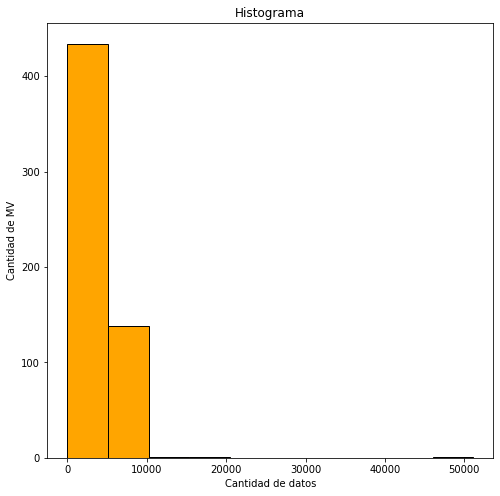

In [9]:
y = df.isna().sum()
num_bins = 10
plt.figure(figsize=(8,8))
plt.hist(y, num_bins, color="orange" , edgecolor='black')
plt.xlabel('Cantidad de datos')
plt.ylabel('Cantidad de MV')
plt.title('Histograma')
plt.show()

**Vemos que hay una gran número de filas con datos nulos en nuestro dataset, sin embargo hay una cantidad importante también de columnas las cuales no tienen datos nulos, por lo que más adelante estaremos separando la data y se curará para quedarnos con la menor cantidad de datos nulos, para no tener que "Inventar" data aplicando imputación.**


# **Fase III. Data Preparation**



Comenzamos a revisar los datos y darnos cuenta de lo que será útil y lo que no para más adelante.


In [10]:
df.columns

Index(['Id', 'Subsegmento', 'Sexo', 'Region', 'Edad', 'Renta', 'Antiguedad',
       'Internauta', 'Adicional', 'Dualidad',
       ...
       'PagoNac_T01', 'PagoInt_T01', 'EeccNac_T01', 'EeccInt_T01', 'UsoL1_T01',
       'UsoL2_T01', 'UsoLI_T01', 'IndRev_T01', 'target', 'Unnamed: 574'],
      dtype='object', length=575)

Al ver el excel, existe una suma que da cuenta de la cantidad de columnas y que está en la misma altura que los headers de las columnas, por lo que se eliminará al no aportar valor está columna está denonimada "Unnamed"

In [11]:
#Usamos la función drop para eliminar la columna anteriormente mencionada
df = df.drop(columns=['Unnamed: 574'])

### Aplicando OneHotEnconder



> Con los aprendizajes del analisis anterior, en primera instancia despejamos los valores no numéricos usando OneHotEncoder



In [89]:
df_0 = df.copy()
cols_a_cambiar = []
helper_0 = df_0.dtypes.to_frame()
helper_0 = helper_0.rename({0:'values'}, axis=1)

In [90]:
helper_0[helper_0.values == 'object']

,values
Sexo,object
IndRev_T12,object
IndRev_T11,object
IndRev_T10,object
IndRev_T09,object
IndRev_T08,object
IndRev_T07,object
IndRev_T06,object
IndRev_T05,object
IndRev_T04,object


In [91]:
helper_0[helper_0.values == 'object'].index

Index(['Sexo', 'IndRev_T12', 'IndRev_T11', 'IndRev_T10', 'IndRev_T09',
       'IndRev_T08', 'IndRev_T07', 'IndRev_T06', 'IndRev_T05', 'IndRev_T04',
       'IndRev_T03', 'IndRev_T02', 'IndRev_T01'],
      dtype='object')

In [92]:
print(df_0[helper_0[helper_0.values == 'object'].index].Sexo.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T12.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T11.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T10.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T09.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T08.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T12.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T07.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T06.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T05.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T04.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T03.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T02.unique())
print(df_0[helper_0[helper_0.values == 'object'].index].IndRev_T01.unique())

['M' 'H' nan]
['R' 'T' 'P' nan]
['R' 'T' 'P' nan]
['R' 'T' nan 'P']
['R' 'T' 'P' nan]
['R' 'T' 'P' nan]
['R' 'T' 'P' nan]
['R' 'T' 'P' nan]
['R' 'T' 'P' nan]
['R' 'T' 'P' nan]
['R' 'T' 'P' nan]
['R' 'T' 'P' nan]
['R' 'T' 'P' nan]
['R' 'T' 'P']




> Para los valores categóricos se contaron los MV



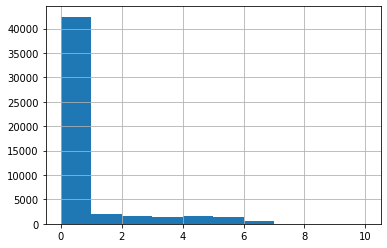

In [93]:
df_0[['Sexo',
 'IndRev_T12',
 'IndRev_T11',
 'IndRev_T10',
 'IndRev_T09',
 'IndRev_T08',
 'IndRev_T07',
 'IndRev_T06',
 'IndRev_T05',
 'IndRev_T04',
 'IndRev_T03',
 'IndRev_T02',
 'IndRev_T01']].isna().sum(axis=1).hist()

In [94]:
s = df_0[['Sexo',
 'IndRev_T12',
 'IndRev_T11',
 'IndRev_T10',
 'IndRev_T09',
 'IndRev_T08',
 'IndRev_T07',
 'IndRev_T06',
 'IndRev_T05',
 'IndRev_T04',
 'IndRev_T03',
 'IndRev_T02',
 'IndRev_T01']].isna().sum(axis=1)
agrupados = s.groupby(s)
agrupados = agrupados.size().to_frame()
agrupados = agrupados.rename({0:'values'}, axis=1)
agrupados

,values
0,42422
1,2029
2,1543
3,1442
4,1622
5,1371
6,656
7,22
8,9
9,5


In [95]:
agrupados['suma_acumulativa'] = agrupados['values'].cumsum()
agrupados['precentil_acumulativo'] = round(100*agrupados['suma_acumulativa']/agrupados['values'].sum(),3)
agrupados

,values,suma_acumulativa,precentil_acumulativo
0,42422,42422,82.979
1,2029,44451,86.947
2,1543,45994,89.966
3,1442,47436,92.786
4,1622,49058,95.959
5,1371,50429,98.641
6,656,51085,99.924
7,22,51107,99.967
8,9,51116,99.984
9,5,51121,99.994


> Con el objetivo de imputar la menor cantidad de data posible al mismo tiempo que se mantiene la cantidad de datos, se decidió por cortar y continuar usando todas las observaciones que tuviesen hasta 1 MV en algunas de las columnas categóricas, lo que conserva el 86.947% de los datos originales.

In [96]:
limpiar_0 = df_0[['Sexo',
 'IndRev_T12',
 'IndRev_T11',
 'IndRev_T10',
 'IndRev_T09',
 'IndRev_T08',
 'IndRev_T07',
 'IndRev_T06',
 'IndRev_T05',
 'IndRev_T04',
 'IndRev_T03',
 'IndRev_T02',
 'IndRev_T01']].isna().sum(axis=1).to_frame()
limpiar_0 = limpiar_0.rename({0:'values'}, axis=1)
df_0.drop(limpiar_0[limpiar_0.values > 2].index, inplace=True)

In [97]:
df_0

,Id,Subsegmento,Sexo,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,Consumo,Hipotecario,Debito,CambioPin,Cuentas,TC,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T12,FlgActCN_T12,FlgActCI_T12,FlgActAN_T12,FlgActAI_T12,FlgActPAT_T12,FlgActCCPC_T12,FlgActCCOT_T12,FlgActCOL_T12,Fac_T12,Txs_T12,FacCN_T12,TxsCN_T12,FacCI_T12,TxsCI_T12,FacAN_T12,TxsAN_T12,FacAI_T12,TxsAI_T12,...,FlgActCCOT_T01,FlgActCOL_T01,Fac_T01,Txs_T01,FacCN_T01,TxsCN_T01,FacCI_T01,TxsCI_T01,FacAN_T01,TxsAN_T01,FacAI_T01,TxsAI_T01,FacPAT_T01,TxsPAT_T01,FacCCPC_T01,TxsCCPC_T01,FacCCOT_T01,TxsCCOT_T01,FacCOL_T01,TxsCOL_T01,FacDebCom_T01,TxsDebCom_T01,FacDebAtm_T01,TxsDebAtm_T01,Col_T01,ColL1T0_T01,ColL1TE_T01,ColL2T0_T01,ColL2AC_T01,ColL2CC_T01,ColMx_T01,PagoNac_T01,PagoInt_T01,EeccNac_T01,EeccInt_T01,UsoL1_T01,UsoL2_T01,UsoLI_T01,IndRev_T01,target
0,1,160,M,13.0,43,NaN,130,1,1,0,0,1,0,0,1,NaN,1,3,798000,1012000.0,1210.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,55490.0,3.0,55490.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,204133,28,24000,2,1069735.0,0,1040339.0,0,0,29396,0.0,33000,0.0,1099866.0,0.0,1099866.0,15080,0.0,R,0
1,2,160,H,13.0,46,143640.0,69,1,0,0,0,1,0,1,0,NaN,1,1,750000,150000.0,1000.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19813.0,1.0,19813.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,118247,1,118247,1,0,0,0,0,0,0,0,0,118247,1,0,0,0,0,0,0,0,0,211884.0,0,162939.0,48945,0,0,0.0,300000,0.0,214592.0,0.0,214592.0,83596,0.0,R,0
2,3,170,H,13.0,45,929106.0,24,1,1,0,0,1,0,1,1,1.0,1,2,1350000,200000.0,1500.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123950.0,3.0,123950.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,191336,3,191336,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,162161,9,519000,11,7400.0,7400,0.0,0,0,0,0.0,216676,0.0,0.0,0.0,7400.0,0,0.0,T,0
3,4,151,H,13.0,46,172447.0,134,0,1,0,1,0,0,0,0,1.0,1,2,1570800,220001.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,44470.0,3.0,44470.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,11890,1,11890,1,0,0,0,0,0,0,0,0,11890,1,0,0,0,0,0,0,0,0,262160.0,0,244048.0,18112,0,0,0.0,60000,0.0,272762.0,0.0,272762.0,10591,0.0,R,0
4,5,170,H,13.0,46,805250.0,116,0,1,1,0,1,0,1,0,1.0,2,3,2762000,2.0,6430.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,138225.0,6.0,138225.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,173576,10,173576,10,0,0,0,0,0,0,0,0,70808,3,47000,1,0,0,0,0,0,0,306161.0,60008,0.0,214125,0,32028,0.0,272925,0.0,249562.0,0.0,75339.0,377782,0.0,R,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51119,51120,160,H,13.0,51,364978.0,57,1,1,1,0,1,0,0,1,1.0,2,3,999000,1000.0,550.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,78520.0,9.0,78520.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,62808,5,62808,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1112000,14,463255.0,62808,379646.0,20801,0,0,0.0,300000,0.0,478320.0,0.0,478320.0,12668,0.0,R,0
51120,51121,170,H,13.0,51,625376.0,39,1,0,0,0,1,0,0,1,1.0,1,1,1744200,1.0,300.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6824.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,37783,1,0,0,0,0,0,0,0,0,37783,1,0,0,0,0,0,0,0,0,0,0,728406.0,37783,0.0,91896,0,598727,0.0,166098,0.0,166098.0,0.0,0.0,572363,0.0,R,0
51121,51122,160,H,13.0,47,806220.0,153,1,1,0,0,1,0,0,1,1.0,1,2,1061000,194700.0,1526.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,66040.0,3.0,66040.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24373.0,0,24.0,0,0,24349,0.0,18891,0.0,9652.0,0.0,9652.0,16241,0.0,R,0
51122,51123,160,M,13.0,47,NaN,11,1,0,0,0,1,0,0,0,NaN,1,1,1612000,300000.0,2300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,108982,2,108982,2,0,0,0,0,0,0,0,0,84982,1,0,0,0,0,0,0,0,0,52360.0,24000,33.0,28327,0,0,0.0,26528,0.0,24638.0,0.0,24638.0,84982,0.0,R,0


> Se prepararán los categóricos usando OneHotEncoder

In [98]:
enc = OneHotEncoder()
data_encoder = enc.fit_transform(df_0[['Sexo',
 'IndRev_T12',
 'IndRev_T11',
 'IndRev_T10',
 'IndRev_T09',
 'IndRev_T08',
 'IndRev_T07',
 'IndRev_T06',
 'IndRev_T05',
 'IndRev_T04',
 'IndRev_T03',
 'IndRev_T02',
 'IndRev_T01']])
dat = data_encoder.toarray()

In [99]:
enc.get_feature_names_out()

array(['Sexo_H', 'Sexo_M', 'IndRev_T12_P', 'IndRev_T12_R', 'IndRev_T12_T',
       'IndRev_T12_nan', 'IndRev_T11_P', 'IndRev_T11_R', 'IndRev_T11_T',
       'IndRev_T11_nan', 'IndRev_T10_P', 'IndRev_T10_R', 'IndRev_T10_T',
       'IndRev_T10_nan', 'IndRev_T09_P', 'IndRev_T09_R', 'IndRev_T09_T',
       'IndRev_T09_nan', 'IndRev_T08_P', 'IndRev_T08_R', 'IndRev_T08_T',
       'IndRev_T08_nan', 'IndRev_T07_P', 'IndRev_T07_R', 'IndRev_T07_T',
       'IndRev_T07_nan', 'IndRev_T06_P', 'IndRev_T06_R', 'IndRev_T06_T',
       'IndRev_T06_nan', 'IndRev_T05_P', 'IndRev_T05_R', 'IndRev_T05_T',
       'IndRev_T05_nan', 'IndRev_T04_P', 'IndRev_T04_R', 'IndRev_T04_T',
       'IndRev_T04_nan', 'IndRev_T03_P', 'IndRev_T03_R', 'IndRev_T03_T',
       'IndRev_T03_nan', 'IndRev_T02_P', 'IndRev_T02_R', 'IndRev_T02_T',
       'IndRev_T02_nan', 'IndRev_T01_P', 'IndRev_T01_R', 'IndRev_T01_T'],
      dtype=object)

> Se obtiene un dataframe con los datos encodeados.

In [100]:
df_enc = pd.DataFrame(dat, columns=enc.get_feature_names_out())
df_enc

,Sexo_H,Sexo_M,IndRev_T12_P,IndRev_T12_R,IndRev_T12_T,IndRev_T12_nan,IndRev_T11_P,IndRev_T11_R,IndRev_T11_T,IndRev_T11_nan,IndRev_T10_P,IndRev_T10_R,IndRev_T10_T,IndRev_T10_nan,IndRev_T09_P,IndRev_T09_R,IndRev_T09_T,IndRev_T09_nan,IndRev_T08_P,IndRev_T08_R,IndRev_T08_T,IndRev_T08_nan,IndRev_T07_P,IndRev_T07_R,IndRev_T07_T,IndRev_T07_nan,IndRev_T06_P,IndRev_T06_R,IndRev_T06_T,IndRev_T06_nan,IndRev_T05_P,IndRev_T05_R,IndRev_T05_T,IndRev_T05_nan,IndRev_T04_P,IndRev_T04_R,IndRev_T04_T,IndRev_T04_nan,IndRev_T03_P,IndRev_T03_R,IndRev_T03_T,IndRev_T03_nan,IndRev_T02_P,IndRev_T02_R,IndRev_T02_T,IndRev_T02_nan,IndRev_T01_P,IndRev_T01_R,IndRev_T01_T
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45989,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45990,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45991,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45992,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [101]:
df_0 = df_0.reset_index()
df_0 = df_0.join(df_enc)
df_0 = df_0.drop(columns=['Id', 'Sexo'])
df_0

,index,Subsegmento,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,Consumo,Hipotecario,Debito,CambioPin,Cuentas,TC,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T12,FlgActCN_T12,FlgActCI_T12,FlgActAN_T12,FlgActAI_T12,FlgActPAT_T12,FlgActCCPC_T12,FlgActCCOT_T12,FlgActCOL_T12,Fac_T12,Txs_T12,FacCN_T12,TxsCN_T12,FacCI_T12,TxsCI_T12,FacAN_T12,TxsAN_T12,FacAI_T12,TxsAI_T12,FacPAT_T12,...,IndRev_T11_nan,IndRev_T10_P,IndRev_T10_R,IndRev_T10_T,IndRev_T10_nan,IndRev_T09_P,IndRev_T09_R,IndRev_T09_T,IndRev_T09_nan,IndRev_T08_P,IndRev_T08_R,IndRev_T08_T,IndRev_T08_nan,IndRev_T07_P,IndRev_T07_R,IndRev_T07_T,IndRev_T07_nan,IndRev_T06_P,IndRev_T06_R,IndRev_T06_T,IndRev_T06_nan,IndRev_T05_P,IndRev_T05_R,IndRev_T05_T,IndRev_T05_nan,IndRev_T04_P,IndRev_T04_R,IndRev_T04_T,IndRev_T04_nan,IndRev_T03_P,IndRev_T03_R,IndRev_T03_T,IndRev_T03_nan,IndRev_T02_P,IndRev_T02_R,IndRev_T02_T,IndRev_T02_nan,IndRev_T01_P,IndRev_T01_R,IndRev_T01_T
0,0,160,13.0,43,NaN,130,1,1,0,0,1,0,0,1,NaN,1,3,798000,1012000.0,1210.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,55490.0,3.0,55490.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1,160,13.0,46,143640.0,69,1,0,0,0,1,0,1,0,NaN,1,1,750000,150000.0,1000.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19813.0,1.0,19813.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2,170,13.0,45,929106.0,24,1,1,0,0,1,0,1,1,1.0,1,2,1350000,200000.0,1500.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123950.0,3.0,123950.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,3,151,13.0,46,172447.0,134,0,1,0,1,0,0,0,0,1.0,1,2,1570800,220001.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,44470.0,3.0,44470.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,4,170,13.0,46,805250.0,116,0,1,1,0,1,0,1,0,1.0,2,3,2762000,2.0,6430.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,138225.0,6.0,138225.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45989,51119,160,13.0,51,364978.0,57,1,1,1,0,1,0,0,1,1.0,2,3,999000,1000.0,550.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,78520.0,9.0,78520.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45990,51120,170,13.0,51,625376.0,39,1,0,0,0,1,0,0,1,1.0,1,1,1744200,1.0,300.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6824.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6824.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45991,51121,160,13.0,47,806220.0,153,1,1,0,0,1,0,0,1,1.0,1,2,1061000,194700.0,1526.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,66040.0,3.0,66040.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45992,51122,160,13.0,47,NaN,11,1,0,0,0,1,0,0,0,NaN,1,1,1612000,300000.0,2300.0,NaN,NaN,NaN,NaN,NaN,N

In [102]:
df_0.drop(columns=["index"], inplace=True)


> Se eliminan los features sin el encoding.

In [103]:
df_0 = df_0.drop(columns=['IndRev_T12',
 'IndRev_T11',
 'IndRev_T10',
 'IndRev_T09',
 'IndRev_T08',
 'IndRev_T07',
 'IndRev_T06',
 'IndRev_T05',
 'IndRev_T04',
 'IndRev_T03',
 'IndRev_T02',
 'IndRev_T01'])
df_0.dtypes

Subsegmento         int64
Region            float64
Edad                int64
Renta             float64
Antiguedad          int64
                   ...   
IndRev_T02_T      float64
IndRev_T02_nan    float64
IndRev_T01_P      float64
IndRev_T01_R      float64
IndRev_T01_T      float64
Length: 609, dtype: object

> Se utiliza KNN Imputer para el imputado de datos

In [104]:
knn_imputer_0 = KNNImputer(n_neighbors=4, weights="uniform")
df_0[enc.get_feature_names_out()] = knn_imputer_0.fit_transform(df_0[enc.get_feature_names_out()])

In [105]:
df_0

,Subsegmento,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,Consumo,Hipotecario,Debito,CambioPin,Cuentas,TC,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T12,FlgActCN_T12,FlgActCI_T12,FlgActAN_T12,FlgActAI_T12,FlgActPAT_T12,FlgActCCPC_T12,FlgActCCOT_T12,FlgActCOL_T12,Fac_T12,Txs_T12,FacCN_T12,TxsCN_T12,FacCI_T12,TxsCI_T12,FacAN_T12,TxsAN_T12,FacAI_T12,TxsAI_T12,FacPAT_T12,TxsPAT_T12,...,IndRev_T11_nan,IndRev_T10_P,IndRev_T10_R,IndRev_T10_T,IndRev_T10_nan,IndRev_T09_P,IndRev_T09_R,IndRev_T09_T,IndRev_T09_nan,IndRev_T08_P,IndRev_T08_R,IndRev_T08_T,IndRev_T08_nan,IndRev_T07_P,IndRev_T07_R,IndRev_T07_T,IndRev_T07_nan,IndRev_T06_P,IndRev_T06_R,IndRev_T06_T,IndRev_T06_nan,IndRev_T05_P,IndRev_T05_R,IndRev_T05_T,IndRev_T05_nan,IndRev_T04_P,IndRev_T04_R,IndRev_T04_T,IndRev_T04_nan,IndRev_T03_P,IndRev_T03_R,IndRev_T03_T,IndRev_T03_nan,IndRev_T02_P,IndRev_T02_R,IndRev_T02_T,IndRev_T02_nan,IndRev_T01_P,IndRev_T01_R,IndRev_T01_T
0,160,13.0,43,NaN,130,1,1,0,0,1,0,0,1,NaN,1,3,798000,1012000.0,1210.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,55490.0,3.0,55490.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,160,13.0,46,143640.0,69,1,0,0,0,1,0,1,0,NaN,1,1,750000,150000.0,1000.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19813.0,1.0,19813.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,170,13.0,45,929106.0,24,1,1,0,0,1,0,1,1,1.0,1,2,1350000,200000.0,1500.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123950.0,3.0,123950.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,151,13.0,46,172447.0,134,0,1,0,1,0,0,0,0,1.0,1,2,1570800,220001.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,44470.0,3.0,44470.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,170,13.0,46,805250.0,116,0,1,1,0,1,0,1,0,1.0,2,3,2762000,2.0,6430.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,138225.0,6.0,138225.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45989,160,13.0,51,364978.0,57,1,1,1,0,1,0,0,1,1.0,2,3,999000,1000.0,550.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,78520.0,9.0,78520.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45990,170,13.0,51,625376.0,39,1,0,0,0,1,0,0,1,1.0,1,1,1744200,1.0,300.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6824.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6824.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45991,160,13.0,47,806220.0,153,1,1,0,0,1,0,0,1,1.0,1,2,1061000,194700.0,1526.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,66040.0,3.0,66040.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45992,160,13.0,47,NaN,11,1,0,0,0,1,0,0,0,NaN,1,1,1612000,300000.0,2300.0,NaN,NaN,NaN,NaN,Na

Se eliminan las columnas encodeadas que significaban nan

In [106]:
cols_nan = []
for i in df_0.columns:
  if i[-4:] == "_nan":
    cols_nan.append(i)
#print(cols_nan)
df_0 = df_0.drop(columns=(cols_nan))
df_0

,Subsegmento,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,Consumo,Hipotecario,Debito,CambioPin,Cuentas,TC,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T12,FlgActCN_T12,FlgActCI_T12,FlgActAN_T12,FlgActAI_T12,FlgActPAT_T12,FlgActCCPC_T12,FlgActCCOT_T12,FlgActCOL_T12,Fac_T12,Txs_T12,FacCN_T12,TxsCN_T12,FacCI_T12,TxsCI_T12,FacAN_T12,TxsAN_T12,FacAI_T12,TxsAI_T12,FacPAT_T12,TxsPAT_T12,...,UsoLI_T01,target,Sexo_H,Sexo_M,IndRev_T12_P,IndRev_T12_R,IndRev_T12_T,IndRev_T11_P,IndRev_T11_R,IndRev_T11_T,IndRev_T10_P,IndRev_T10_R,IndRev_T10_T,IndRev_T09_P,IndRev_T09_R,IndRev_T09_T,IndRev_T08_P,IndRev_T08_R,IndRev_T08_T,IndRev_T07_P,IndRev_T07_R,IndRev_T07_T,IndRev_T06_P,IndRev_T06_R,IndRev_T06_T,IndRev_T05_P,IndRev_T05_R,IndRev_T05_T,IndRev_T04_P,IndRev_T04_R,IndRev_T04_T,IndRev_T03_P,IndRev_T03_R,IndRev_T03_T,IndRev_T02_P,IndRev_T02_R,IndRev_T02_T,IndRev_T01_P,IndRev_T01_R,IndRev_T01_T
0,160,13.0,43,NaN,130,1,1,0,0,1,0,0,1,NaN,1,3,798000,1012000.0,1210.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,55490.0,3.0,55490.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,160,13.0,46,143640.0,69,1,0,0,0,1,0,1,0,NaN,1,1,750000,150000.0,1000.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19813.0,1.0,19813.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,170,13.0,45,929106.0,24,1,1,0,0,1,0,1,1,1.0,1,2,1350000,200000.0,1500.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123950.0,3.0,123950.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,151,13.0,46,172447.0,134,0,1,0,1,0,0,0,0,1.0,1,2,1570800,220001.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,44470.0,3.0,44470.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,170,13.0,46,805250.0,116,0,1,1,0,1,0,1,0,1.0,2,3,2762000,2.0,6430.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,138225.0,6.0,138225.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45989,160,13.0,51,364978.0,57,1,1,1,0,1,0,0,1,1.0,2,3,999000,1000.0,550.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,78520.0,9.0,78520.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45990,170,13.0,51,625376.0,39,1,0,0,0,1,0,0,1,1.0,1,1,1744200,1.0,300.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6824.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6824.0,1.0,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45991,160,13.0,47,806220.0,153,1,1,0,0,1,0,0,1,1.0,1,2,1061000,194700.0,1526.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,66040.0,3.0,66040.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45992,160,13.0,47,NaN,11,1,0,0,0,1,0,0,0,NaN,1,1,1612000,300000.0,2300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [107]:
df_0

,Subsegmento,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,Consumo,Hipotecario,Debito,CambioPin,Cuentas,TC,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T12,FlgActCN_T12,FlgActCI_T12,FlgActAN_T12,FlgActAI_T12,FlgActPAT_T12,FlgActCCPC_T12,FlgActCCOT_T12,FlgActCOL_T12,Fac_T12,Txs_T12,FacCN_T12,TxsCN_T12,FacCI_T12,TxsCI_T12,FacAN_T12,TxsAN_T12,FacAI_T12,TxsAI_T12,FacPAT_T12,TxsPAT_T12,...,UsoLI_T01,target,Sexo_H,Sexo_M,IndRev_T12_P,IndRev_T12_R,IndRev_T12_T,IndRev_T11_P,IndRev_T11_R,IndRev_T11_T,IndRev_T10_P,IndRev_T10_R,IndRev_T10_T,IndRev_T09_P,IndRev_T09_R,IndRev_T09_T,IndRev_T08_P,IndRev_T08_R,IndRev_T08_T,IndRev_T07_P,IndRev_T07_R,IndRev_T07_T,IndRev_T06_P,IndRev_T06_R,IndRev_T06_T,IndRev_T05_P,IndRev_T05_R,IndRev_T05_T,IndRev_T04_P,IndRev_T04_R,IndRev_T04_T,IndRev_T03_P,IndRev_T03_R,IndRev_T03_T,IndRev_T02_P,IndRev_T02_R,IndRev_T02_T,IndRev_T01_P,IndRev_T01_R,IndRev_T01_T
0,160,13.0,43,NaN,130,1,1,0,0,1,0,0,1,NaN,1,3,798000,1012000.0,1210.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,55490.0,3.0,55490.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,160,13.0,46,143640.0,69,1,0,0,0,1,0,1,0,NaN,1,1,750000,150000.0,1000.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19813.0,1.0,19813.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,170,13.0,45,929106.0,24,1,1,0,0,1,0,1,1,1.0,1,2,1350000,200000.0,1500.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123950.0,3.0,123950.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,151,13.0,46,172447.0,134,0,1,0,1,0,0,0,0,1.0,1,2,1570800,220001.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,44470.0,3.0,44470.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,170,13.0,46,805250.0,116,0,1,1,0,1,0,1,0,1.0,2,3,2762000,2.0,6430.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,138225.0,6.0,138225.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45989,160,13.0,51,364978.0,57,1,1,1,0,1,0,0,1,1.0,2,3,999000,1000.0,550.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,78520.0,9.0,78520.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45990,170,13.0,51,625376.0,39,1,0,0,0,1,0,0,1,1.0,1,1,1744200,1.0,300.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6824.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6824.0,1.0,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45991,160,13.0,47,806220.0,153,1,1,0,0,1,0,0,1,1.0,1,2,1061000,194700.0,1526.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,66040.0,3.0,66040.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45992,160,13.0,47,NaN,11,1,0,0,0,1,0,0,0,NaN,1,1,1612000,300000.0,2300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

Volviendo a revisar MV:

In [109]:
df_1 = df_0.copy()
s = df_1.isna().sum(axis=1)
agrupados = s.groupby(s)
agrupados = agrupados.size().to_frame()
agrupados = agrupados.rename({0:'values'}, axis=1)
agrupados

,values
0,19032
1,18990
2,4394
3,6
45,942
46,925
47,162
90,750
91,675
92,118


In [110]:
agrupados['suma_acumulativa'] = agrupados['values'].cumsum()
agrupados['precentil_acumulativo'] = round(100*agrupados['suma_acumulativa']/agrupados['values'].sum(),3)
agrupados

,values,suma_acumulativa,precentil_acumulativo
0,19032,19032,41.379
1,18990,38022,82.667
2,4394,42416,92.221
3,6,42422,92.234
45,942,43364,94.282
46,925,44289,96.293
47,162,44451,96.645
90,750,45201,98.276
91,675,45876,99.743
92,118,45994,100.000


Anteriormente se imputaron las columnas con features categóricos, ahora se verá el dataset_01 en su totalidad. Es visibe que al tomar las filas con hasta 2 MV, estamos considerando el 92.221% de los datos orginales, por lo que se procederá a limpiar el resto. Todo esto con el fin de imputar la menor cantidad posible de datos, para mantener la calidad original del dataset_01

In [111]:
limpiar_1 = df_1.isna().sum(axis=1).to_frame()
limpiar_1 = limpiar_1.rename({0:'values'}, axis=1)
df_1 = df_1.drop(limpiar_1[limpiar_1.values > 2].index)

In [112]:
df_1

,Subsegmento,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,Consumo,Hipotecario,Debito,CambioPin,Cuentas,TC,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T12,FlgActCN_T12,FlgActCI_T12,FlgActAN_T12,FlgActAI_T12,FlgActPAT_T12,FlgActCCPC_T12,FlgActCCOT_T12,FlgActCOL_T12,Fac_T12,Txs_T12,FacCN_T12,TxsCN_T12,FacCI_T12,TxsCI_T12,FacAN_T12,TxsAN_T12,FacAI_T12,TxsAI_T12,FacPAT_T12,TxsPAT_T12,...,UsoLI_T01,target,Sexo_H,Sexo_M,IndRev_T12_P,IndRev_T12_R,IndRev_T12_T,IndRev_T11_P,IndRev_T11_R,IndRev_T11_T,IndRev_T10_P,IndRev_T10_R,IndRev_T10_T,IndRev_T09_P,IndRev_T09_R,IndRev_T09_T,IndRev_T08_P,IndRev_T08_R,IndRev_T08_T,IndRev_T07_P,IndRev_T07_R,IndRev_T07_T,IndRev_T06_P,IndRev_T06_R,IndRev_T06_T,IndRev_T05_P,IndRev_T05_R,IndRev_T05_T,IndRev_T04_P,IndRev_T04_R,IndRev_T04_T,IndRev_T03_P,IndRev_T03_R,IndRev_T03_T,IndRev_T02_P,IndRev_T02_R,IndRev_T02_T,IndRev_T01_P,IndRev_T01_R,IndRev_T01_T
0,160,13.0,43,NaN,130,1,1,0,0,1,0,0,1,NaN,1,3,798000,1012000.0,1210.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,55490.0,3.0,55490.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,160,13.0,46,143640.0,69,1,0,0,0,1,0,1,0,NaN,1,1,750000,150000.0,1000.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19813.0,1.0,19813.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,170,13.0,45,929106.0,24,1,1,0,0,1,0,1,1,1.0,1,2,1350000,200000.0,1500.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123950.0,3.0,123950.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,151,13.0,46,172447.0,134,0,1,0,1,0,0,0,0,1.0,1,2,1570800,220001.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,44470.0,3.0,44470.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,170,13.0,46,805250.0,116,0,1,1,0,1,0,1,0,1.0,2,3,2762000,2.0,6430.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,138225.0,6.0,138225.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45988,160,13.0,44,414316.0,23,1,0,1,0,1,0,0,1,NaN,2,2,1020000,440000.0,1600.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3500.0,1.0,...,0.0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
45989,160,13.0,51,364978.0,57,1,1,1,0,1,0,0,1,1.0,2,3,999000,1000.0,550.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,78520.0,9.0,78520.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45990,170,13.0,51,625376.0,39,1,0,0,0,1,0,0,1,1.0,1,1,1744200,1.0,300.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6824.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6824.0,1.0,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45991,160,13.0,47,806220.0,153,1,1,0,0,1,0,0,1,1.0,1,2,1061000,194700.0,1526.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,66040.0,3.0,66040.0,3.0,0.0,0.0,0.0,

In [113]:
knn_imputer_1 = KNNImputer(n_neighbors=4, weights="uniform")
#df_0[enc.get_feature_names_out()] = knn_imputer_0.fit_transform(df_0[enc.get_feature_names_out()])

In [114]:
nan_cols = [i for i in df_1.columns if df_1[i].isnull().any()]
nan_cols

['Region', 'Renta', 'CambioPin']

In [115]:
df_1[['Region', 'Renta', 'CambioPin']] = knn_imputer_1.fit_transform(df_1[['Region', 'Renta', 'CambioPin']])

In [116]:
df_1

,Subsegmento,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,Consumo,Hipotecario,Debito,CambioPin,Cuentas,TC,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T12,FlgActCN_T12,FlgActCI_T12,FlgActAN_T12,FlgActAI_T12,FlgActPAT_T12,FlgActCCPC_T12,FlgActCCOT_T12,FlgActCOL_T12,Fac_T12,Txs_T12,FacCN_T12,TxsCN_T12,FacCI_T12,TxsCI_T12,FacAN_T12,TxsAN_T12,FacAI_T12,TxsAI_T12,FacPAT_T12,TxsPAT_T12,...,UsoLI_T01,target,Sexo_H,Sexo_M,IndRev_T12_P,IndRev_T12_R,IndRev_T12_T,IndRev_T11_P,IndRev_T11_R,IndRev_T11_T,IndRev_T10_P,IndRev_T10_R,IndRev_T10_T,IndRev_T09_P,IndRev_T09_R,IndRev_T09_T,IndRev_T08_P,IndRev_T08_R,IndRev_T08_T,IndRev_T07_P,IndRev_T07_R,IndRev_T07_T,IndRev_T06_P,IndRev_T06_R,IndRev_T06_T,IndRev_T05_P,IndRev_T05_R,IndRev_T05_T,IndRev_T04_P,IndRev_T04_R,IndRev_T04_T,IndRev_T03_P,IndRev_T03_R,IndRev_T03_T,IndRev_T02_P,IndRev_T02_R,IndRev_T02_T,IndRev_T01_P,IndRev_T01_R,IndRev_T01_T
0,160,13.0,43,516234.5,130,1,1,0,0,1,0,0,1,1.0,1,3,798000,1012000.0,1210.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,55490.0,3.0,55490.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,160,13.0,46,143640.0,69,1,0,0,0,1,0,1,0,1.0,1,1,750000,150000.0,1000.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19813.0,1.0,19813.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,170,13.0,45,929106.0,24,1,1,0,0,1,0,1,1,1.0,1,2,1350000,200000.0,1500.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123950.0,3.0,123950.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,151,13.0,46,172447.0,134,0,1,0,1,0,0,0,0,1.0,1,2,1570800,220001.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,44470.0,3.0,44470.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,170,13.0,46,805250.0,116,0,1,1,0,1,0,1,0,1.0,2,3,2762000,2.0,6430.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,138225.0,6.0,138225.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45988,160,13.0,44,414316.0,23,1,0,1,0,1,0,0,1,1.0,2,2,1020000,440000.0,1600.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3500.0,1.0,...,0.0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
45989,160,13.0,51,364978.0,57,1,1,1,0,1,0,0,1,1.0,2,3,999000,1000.0,550.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,78520.0,9.0,78520.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45990,170,13.0,51,625376.0,39,1,0,0,0,1,0,0,1,1.0,1,1,1744200,1.0,300.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6824.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6824.0,1.0,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45991,160,13.0,47,806220.0,153,1,1,0,0,1,0,0,1,1.0,1,2,1061000,194700.0,1526.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,66040.0,3.0,66040.0,3.0,0.0,0.0

## Normalización

In [117]:
df_2 = df_1.copy()
df_2

,Subsegmento,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,Consumo,Hipotecario,Debito,CambioPin,Cuentas,TC,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T12,FlgActCN_T12,FlgActCI_T12,FlgActAN_T12,FlgActAI_T12,FlgActPAT_T12,FlgActCCPC_T12,FlgActCCOT_T12,FlgActCOL_T12,Fac_T12,Txs_T12,FacCN_T12,TxsCN_T12,FacCI_T12,TxsCI_T12,FacAN_T12,TxsAN_T12,FacAI_T12,TxsAI_T12,FacPAT_T12,TxsPAT_T12,...,UsoLI_T01,target,Sexo_H,Sexo_M,IndRev_T12_P,IndRev_T12_R,IndRev_T12_T,IndRev_T11_P,IndRev_T11_R,IndRev_T11_T,IndRev_T10_P,IndRev_T10_R,IndRev_T10_T,IndRev_T09_P,IndRev_T09_R,IndRev_T09_T,IndRev_T08_P,IndRev_T08_R,IndRev_T08_T,IndRev_T07_P,IndRev_T07_R,IndRev_T07_T,IndRev_T06_P,IndRev_T06_R,IndRev_T06_T,IndRev_T05_P,IndRev_T05_R,IndRev_T05_T,IndRev_T04_P,IndRev_T04_R,IndRev_T04_T,IndRev_T03_P,IndRev_T03_R,IndRev_T03_T,IndRev_T02_P,IndRev_T02_R,IndRev_T02_T,IndRev_T01_P,IndRev_T01_R,IndRev_T01_T
0,160,13.0,43,516234.5,130,1,1,0,0,1,0,0,1,1.0,1,3,798000,1012000.0,1210.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,55490.0,3.0,55490.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,160,13.0,46,143640.0,69,1,0,0,0,1,0,1,0,1.0,1,1,750000,150000.0,1000.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19813.0,1.0,19813.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,170,13.0,45,929106.0,24,1,1,0,0,1,0,1,1,1.0,1,2,1350000,200000.0,1500.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123950.0,3.0,123950.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,151,13.0,46,172447.0,134,0,1,0,1,0,0,0,0,1.0,1,2,1570800,220001.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,44470.0,3.0,44470.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,170,13.0,46,805250.0,116,0,1,1,0,1,0,1,0,1.0,2,3,2762000,2.0,6430.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,138225.0,6.0,138225.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45988,160,13.0,44,414316.0,23,1,0,1,0,1,0,0,1,1.0,2,2,1020000,440000.0,1600.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3500.0,1.0,...,0.0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
45989,160,13.0,51,364978.0,57,1,1,1,0,1,0,0,1,1.0,2,3,999000,1000.0,550.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,78520.0,9.0,78520.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45990,170,13.0,51,625376.0,39,1,0,0,0,1,0,0,1,1.0,1,1,1744200,1.0,300.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6824.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6824.0,1.0,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45991,160,13.0,47,806220.0,153,1,1,0,0,1,0,0,1,1.0,1,2,1061000,194700.0,1526.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,66040.0,3.0,66040.0,3.0,0.0,0.0

In [118]:
Q1 = df_2.quantile(0.25)
Q3 = df_2.quantile(0.75)
IQR = Q3 - Q1
((df_2 < (Q1 - 1.5 * IQR)) | (df_2 > (Q3 + 1.5 * IQR))).sum()

Subsegmento       36
Region          1617
Edad             218
Renta           1653
Antiguedad      2007
                ... 
IndRev_T02_R       0
IndRev_T02_T    8580
IndRev_T01_P    3464
IndRev_T01_R       0
IndRev_T01_T    7740
Length: 598, dtype: int64

### Aplicando MinMaxScaler

> Debido a la distribución de outliers, se aplicará MinMax al dateset, desde ahora dataset_01.

In [119]:
scaler = MinMaxScaler()
scaler.fit(df_2)
array_scaler = scaler.transform(df_2)

In [120]:
df_3 = pd.DataFrame(array_scaler)
df_3.columns = df_2.columns
df_3.describe()

,Subsegmento,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,Consumo,Hipotecario,Debito,CambioPin,Cuentas,TC,CUPO_L1,CUPO_L2,CUPO_MX,FlgAct_T12,FlgActCN_T12,FlgActCI_T12,FlgActAN_T12,FlgActAI_T12,FlgActPAT_T12,FlgActCCPC_T12,FlgActCCOT_T12,FlgActCOL_T12,Fac_T12,Txs_T12,FacCN_T12,TxsCN_T12,FacCI_T12,TxsCI_T12,FacAN_T12,TxsAN_T12,FacAI_T12,TxsAI_T12,FacPAT_T12,TxsPAT_T12,...,UsoLI_T01,target,Sexo_H,Sexo_M,IndRev_T12_P,IndRev_T12_R,IndRev_T12_T,IndRev_T11_P,IndRev_T11_R,IndRev_T11_T,IndRev_T10_P,IndRev_T10_R,IndRev_T10_T,IndRev_T09_P,IndRev_T09_R,IndRev_T09_T,IndRev_T08_P,IndRev_T08_R,IndRev_T08_T,IndRev_T07_P,IndRev_T07_R,IndRev_T07_T,IndRev_T06_P,IndRev_T06_R,IndRev_T06_T,IndRev_T05_P,IndRev_T05_R,IndRev_T05_T,IndRev_T04_P,IndRev_T04_R,IndRev_T04_T,IndRev_T03_P,IndRev_T03_R,IndRev_T03_T,IndRev_T02_P,IndRev_T02_R,IndRev_T02_T,IndRev_T01_P,IndRev_T01_R,IndRev_T01_T
count,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.0,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,...,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.00000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000,42416.000000
mean,0.044766,0.822889,0.245582,0.048013,0.121510,0.675288,0.274495,0.368611,0.072991,0.913877,0.000943,0.148647,0.855125,0.0,0.099721,0.067817,0.057195,0.028588,0.037533,0.659845,0.582634,0.033619,0.023010,0.002617,0.139664,0.277890,0.107672,0.003136,0.107060,0.079018,0.154260,0.072773,0.001985,0.002737,0.001103,0.004560,0.000529,0.000326,0.004052,0.019108,...,0.665299,0.094658,0.536637,0.463363,0.156356,0.627075,0.216569,0.132662,0.644521,0.222817,0.119177,0.669582,0.211241,0.105550,0.678022,0.216428,0.096850,0.697237,0.205913,0.079946,0.717135,0.202919,0.083931,0.708530,0.20754,0.078249,0.741300,0.180451,0.069455,0.768389,0.162156,0.065188,0.739131,0.195681,0.072119,0.725599,0.202282,0.081667,0.735854,0.182478
std,0.042800,0.279946,0.159993,0.028427,0.113751,0.468273,0.446265,0.482434,0.260125,0.280549,0.030695,0.355744,0.351978,0.0,0.139393,0.081042,0.052265,0.064109,0.042069,0.473767,0.493130,0.180250,0.149937,0.051090,0.346642,0.447964,0.309969,0.055909,0.024380,0.064389,0.031700,0.061406,0.021019,0.023307,0.013870,0.036499,0.015215,0.009134,0.019811,0.059490,...,0.009456,0.292745,0.498662,0.498662,0.363197,0.483588,0.411911,0.339213,0.478664,0.416141,0.324000,0.470369,0.408194,0.307264,0.467240,0.411814,0.295757,0.459459,0.404372,0.271213,0.450397,0.402177,0.277287,0.454445,0.40555,0.268566,0.437925,0.384567,0.254229,0.421867,0.368598,0.246860,0.439114,0.396729,0.258688,0.446217,0.401706,0.273860,0.440882,0.386243
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,

## PCA


Primero, ya que no estamos evaluando un modelo supervisado, debemos eliminar el feature target

In [121]:
df_3 = df_3.drop(columns=["target"])

In [128]:
pca = PCA(n_components = 300)
pca.fit(df_3)

PCA(n_components=300)

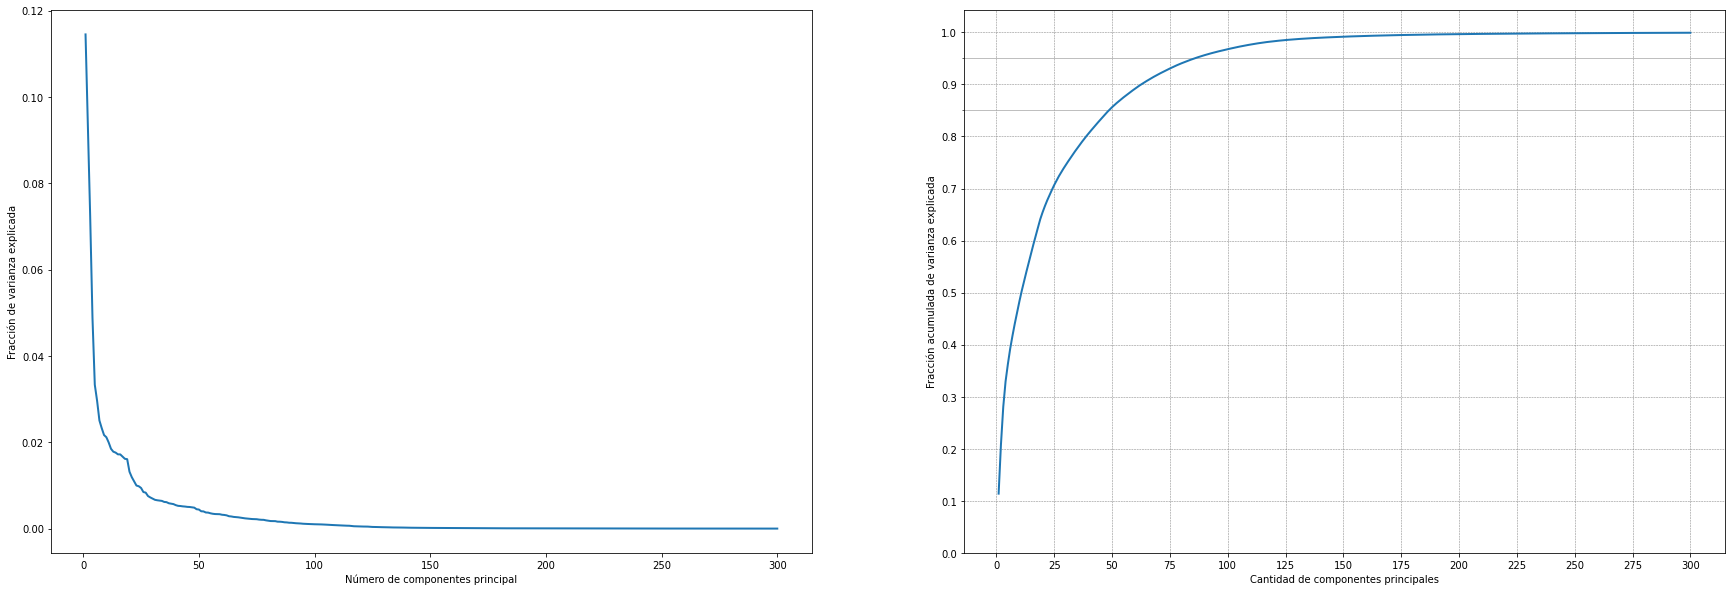

In [151]:
# con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = pca.explained_variance_ratio_

# Graficamos la fracción de varianza que aporta cada componente y la información acumulada
fig, ax = plt.subplots(1, 2, figsize = (30, 10))

ax[0].plot(range(1, len(evr) + 1), evr, '-', linewidth = 2)
ax[0].set_ylabel('Fracción de varianza explicada')
ax[0].set_xlabel('Número de componentes principal')


# Calculamos el acumulado con la función cumsum de numpy 
varianza_acumulada = np.cumsum(evr)
ax[1].plot(range(1, len(evr) + 1), varianza_acumulada, '-', linewidth = 2)
ax[1].set_ylabel('Fracción acumulada de varianza explicada')
ax[1].set_xlabel('Cantidad de componentes principales')

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
ax[1].set_xticks([i for i in range(0, 301, 25)], minor=False)
ax[1].set_yticks([i/100 for i in range(0, 110, 10)], minor=False)
ax[1].set_yticks([0.7, 0.85, 0.9, 0.95], minor=True)
ax[1].xaxis.grid(True, which='major')
ax[1].yaxis.grid(True, which='minor')
plt.show()

De lo anterior se observa que 

# **Fase IV. Modeling**

# Fase V. Evaluation.

### Métricas

### Análisis final

**Gracias al estudio y procesamiento de esta data, se pudieron obtener resultados más que satisfactorios, no así con nuestro objetivo anterior, ya que la desición de cambiar de objetivo fue efectivamente por malos resultados y debido a esto descubrimos un target que si tenía correlación con la data y en consecuencia buenos modelados y predicciones, obteniendo nuestros mejores resultados en el Árbol de clasificación número 2, donde la separación de la data era de un 70% para el entrenamiento y un 30% para el testeo y se usó un límite de correlación de 0.1. En cuanto a métricas, este modelo es ligeramente mejor que el modelo Arbol 2 exp, pero definimos al primero como ideal para este negocio debido a la importancia de obtener resultados certeros, sin  cuidado de el tiempo de entrenamiento.**

**El objetivo inicial se pudo llevar a cabo y predecir con gran probabilidad, pudiendo así el banco Dormammu saber cúales clientes del recientemente adquirido banco Monopoly serán los que quedarán con deuda y cuales clientes pagarán la deuda total.**

In [ ]:
print(confusion_matrix(Y_test_2, y_pred_arbol_2))
print(classification_report(Y_test_2, y_pred_arbol_2))
auc_score_arbol_2 = roc_auc_score(Y_test_2, y_pred_arbol_2)
print('AUC score: ', auc_score_arbol_2)

[[11762   627]
 [  503   822]]
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95     12389
         1.0       0.57      0.62      0.59      1325

    accuracy                           0.92     13714
   macro avg       0.76      0.78      0.77     13714
weighted avg       0.92      0.92      0.92     13714

AUC score:  0.784883973457891


**El valor de recall en 0.62 es aceptable debido a que el objetivo del negocio es detectar a los clientes que no quedarán con deuda para su próximo pago, dando preferencia a lás métricas relacionadas a la clase "0.0", teniendo 0.96 de presición, 0.95 de recall y 0.92 de accuracy**

---
                                                        Fin Prueba 3
---